## 2. Encoder-Decoder sobre imágenes

En la presente seccion se experimentará con arquitecturas del tipo *encoder-decoder* [[3]](#refs) aplicadas sobre imágenes, tales como *image translation*, *object location*, *image segmentation*, entre otros. La idea es aplicar una red convolucional en ambas partes del modelo (encoder y decoder), así utilizamos un modelo que se adapte a estos casos.

La tarea consistirá en realizar **Image Segmentation** [[4]](#refs) para identificar ciertos segmentos o regiones de interés en una imagen a través de procesar de manera semántica (en la codificación) si cada pixel corresponde a un segmento a destacar. Esta tarea puede ser aplicada tanto para identificar un segmento como para identificar múltiples segmentos a través de colocar varios canales/filtros de salida en el *decoder*. Para ésto trabajaremos con un dataset creado en el área (*A BENCHMARK FOR SEMANTIC IMAGE SEGMENTATION*). El dataset resulta bastante pequeño en cantidad de datos, por lo que deberá pensar en formas de conllevar ésto.

<img src="https://qph.fs.quoracdn.net/main-qimg-78a617ec1de942814c3d23dab7de0b24" width="70%" />

In [0]:
import numpy as np
import os
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D, Conv2DTranspose, UpSampling2D, BatchNormalization
from sklearn.metrics import precision_score, recall_score
from skimage import filters
from numpy.random import binomial
%matplotlib inline

Primero se importan los datos a utilizar y se redimensionan las imagenes a un tamaño fijo de 100x100 ya que no se cuenta con muchos datos por lo que es mejor utilizar un tamaño de imagen pequeño ya que esto reduce el numero de caracteristicas. Ademas, las imagenes de este tamaño aun son facilmente apreciables.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
img_size = 100
folder = "/content/drive/My Drive/Semanticdataset100"
data = [archivo.split(".")[0] for archivo in os.listdir(folder+"/image")]
X_image = []
for archivo in data:
    I = Image.open(folder+"/image/"+archivo+".jpg")
    I = np.asarray(I.resize((img_size,img_size), Image.ANTIALIAS))
    X_image.append(I)
X_image = np.asarray(X_image)
Y_image = []
for archivo in data:
    I = Image.open(folder+"/ground-truth/"+archivo+".png")
    I = np.asarray(I.resize((img_size,img_size), Image.ANTIALIAS))
    Y_image.append(I)
Y_image = np.asarray(Y_image)

**a) Explore los datos a trabajar, visualice la entrada y salida del modelo, además de las dimensionalidades de éstas ¿Es un problema las dimensiones de los datos versus la cantidad de datos a entrenar? Normalice los datos como se acostumbra en imágenes y genere una dimensión/canal extra a la salida.**


Para visualizar el tipo de datos, se puede ver una imagen del input, que es una imagen a color, y output, que es una imagen en escala de grises mostrando la segmentacion de la imagen anterior. Ambas imagenes son del mismo tamaño (100x100), pero la entrada tiene tres canales de color. 

La poca cantidad de imagenes de entrenamiento si podria ser un problema, pero se esperaria que este sea reducido al usar redes convolucionales, que tienen menos pesos que entrenar.

Dimension de entrada: (100, 100, 3)
Dimension de salida: (100, 100)


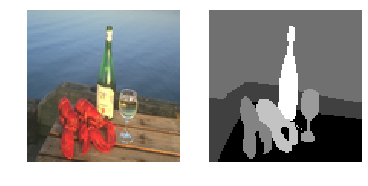

In [0]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(Image.fromarray(X_image[30], 'RGB'))
ax[1].imshow(Image.fromarray(Y_image[30]), cmap='gray', vmin=0, vmax=255)
ax[0].set_axis_off()
ax[1].set_axis_off()
print("Dimension de entrada:", X_image[30].shape)
print("Dimension de salida:", Y_image[30].shape)

**b) Separe 10 imágenes como conjunto de pruebas para verificar la calidad del modelo entrenado.**

In [0]:
origx = X_image
origy = Y_image

X_image = X_image/255.
Y_image = Y_image/255.
Y_image = Y_image[:,:,:,None]

x_train = X_image[:90]
y_train = Y_image[:90]
x_test = X_image[90:]
y_test = Y_image[90:]

print("Ejemplos de training:", x_train.shape[0])
print("Ejemplos de test:", x_test.shape[0])

Ejemplos de training: 90
Ejemplos de test: 10


**c) Debido a la poca cantidad de datos presentes defina la arquitectura a utilizando únicamente convolucionales (fully convolutional) [5], como la presente en el código. Comente sobre los cambios en la dimensionalidad a través del forward pass. Decida el tamaño del batch en base a la cantidad de datos que se presenta para entrenar.**

In [0]:
def newModel():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=X_image.shape[1:]))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPool2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPool2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))

    model.add(UpSampling2D((2, 2)))
    model.add(Conv2DTranspose(32, (3, 3), activation='relu', padding='same'))
    model.add(Conv2DTranspose(32, (3, 3), activation='relu', padding='same'))
    model.add(Conv2DTranspose(1, (3, 3), strides=(2,2), activation='sigmoid', padding='same'))
    
    return model

newModel().summary()


W0805 22:04:48.695519 140566895691648 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 128)       7


Esta red tiene dos partes: en la primera, el encoder, la dimensionalidad se va reduciendo mediante capas de pooling, pasando de 100x100 a 50x50 a 25x25. En la segunda parte, el decoder se aumenta la dimensionalidad para volver al tamaño original de 100x100.

W0805 22:04:49.202210 140566895691648 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


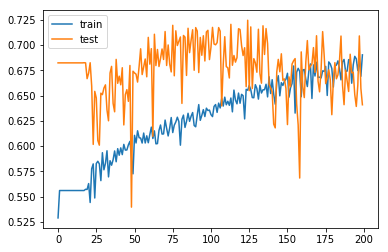

In [0]:
def trainModel(x, y, xt, yt, model, bs):
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=["accuracy"])
    history = model.fit(x, y, epochs=200, batch_size=bs, validation_data=(xt, yt), verbose=0)
    return history


model = newModel()
h = trainModel(x_train, y_train, x_test, y_test, model, 16)
plt.figure()
plt.plot(h.history['acc'], label='train')
plt.plot(h.history['val_acc'], label='test')
plt.legend()

**d) Para medir el desempeño del modelo sobre ambos conjuntos realice un análisis cualitativo en base a visualizar la segmentación que realiza versus la segmentación real, además de verificar el precision y recall asumiendo valores binarios de pixel ¿Qué valor debería ser más importante los ceros o 1? Comente.**

In [0]:
Y_hat_train = np.squeeze(model.predict(x_train))
Y_hat_test = np.squeeze(model.predict(x_test))

In [0]:
y_hat_img = (Y_hat_train*255).astype(np.uint8)
y_hat_test_img = (Y_hat_test*255).astype(np.uint8)

Se comparan los resultados entregados por la red con la segmentacion real para los conjuntos de prueba y entrenamiento.

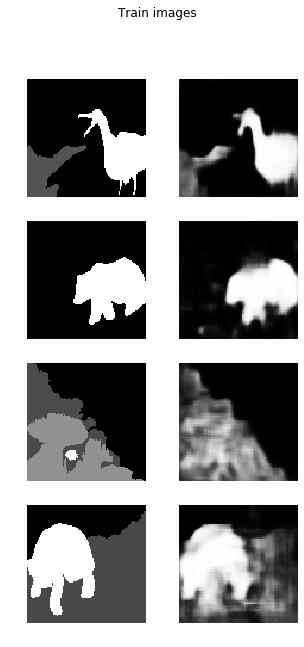

In [0]:
fig, ax = plt.subplots(4,2, figsize=(5,10))
fig.suptitle("Train images")
ind = 0
for i in ax:
    i[0].imshow(Image.fromarray(origy[ind]), cmap='gray', vmin=0, vmax=255)
    i[1].imshow(Image.fromarray(y_hat_img[ind]), cmap='gray', vmin=0, vmax=255)
    i[0].set_axis_off()
    i[1].set_axis_off()
    ind += 1


Se puede ver que  la segmentacion es mejor en algunas imagenes que otras, particularmente las que tienen mucho blanco. Además, la segmentacion realizada por la red es mucho más "borrosa" que la original, que tiene bordes bien definidos y grandes areas del mismo tono.

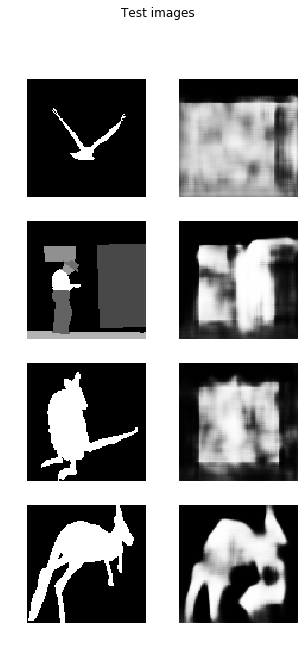

In [0]:
fig, ax = plt.subplots(4,2, figsize=(5,10))
fig.suptitle("Test images")
ind = 0
for i in ax:
    i[0].imshow(Image.fromarray(origy[90+ind]), cmap='gray', vmin=0, vmax=255)
    i[1].imshow(Image.fromarray(y_hat_test_img[ind]), cmap='gray', vmin=0, vmax=255)
    i[0].set_axis_off()
    i[1].set_axis_off()
    ind += 1

En las imagenes se puede ver que la segmentacion en el conjunto de pruebas es bastante peor.

Luego se analizan la precision y recall de ambos conjuntos para medir su desempeño cuantitativamente. Para esto, se transforma a los pixeles en blanco o negro. 

In [0]:
Y_label = y_train.flatten() > 0.5
Y_hat_label = Y_hat_train.flatten() > 0.5
print("Precision:", precision_score(Y_label, Y_hat_label, average=None, labels=[0,1] ))
print("Recall:", recall_score(Y_label, Y_hat_label, average=None , labels=[0,1]))

Y_label = y_test.flatten() > 0.5
Y_hat_label = Y_hat_test.flatten() > 0.5
print("\nTest Precision:", precision_score(Y_label, Y_hat_label, average=None, labels=[0,1] ))
print("Test Recall:", recall_score(Y_label, Y_hat_label, average=None , labels=[0,1]))

Precision: [0.93026595 0.86978027]
Recall: [0.93531982 0.86036988]

Test Precision: [0.89785017 0.44234272]
Test Recall: [0.77946119 0.66359889]


Aqui se ve que la precision y recall son particularmente altos en los casos de los 0s, pero para este problema es más importante que los 1s esten clasificados correctamente ya que estas son las areas que se quiere identificar.

También se puede ver que la calidad en el conjunto de pruebas es mucho menor que en el de training, en especial al clasificar 1s, esto es congruete con lo que se observó cualitativamente en las imagenes anteriores.



**e) Compárese con alguna técnica manual de Image Segmentation, comúnmente se sugiere considerar un treshold para activar o apagar un píxel. Experimente con utilizar treshold igual a la media o con otra técnica más inteligente basada en los histogramas de escala de grises, como se utilizan en skimage.**

Primero, se utiliza una tecnica que usa un treshold igual a la media de la imagen para activar o apagar un pixel:

In [0]:
gray_X = 0.2125*X_image[:,:,:,0]+ 0.7154*X_image[:,:,:,1]+ 0.0721*X_image[:,:,:,2] #needed gray-scale
val = gray_X.mean() 
mask = gray_X < val
X_segmented = mask*1

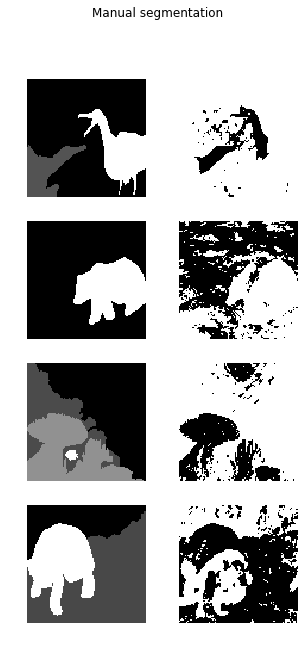

In [0]:
segmented_img = (X_segmented*255).astype(np.uint8)
fig, ax = plt.subplots(4, 2, figsize=(5,10))
fig.suptitle("Manual segmentation")
ind = 0
for i in ax:
    i[0].imshow(Image.fromarray(origy[ind]), cmap='gray', vmin=0, vmax=255)
    i[1].imshow(Image.fromarray(segmented_img[ind]), cmap='gray', vmin=0, vmax=255)
    i[0].set_axis_off()
    i[1].set_axis_off()
    ind += 1

En las imagenes se ve que esta tecnica reconoce algunas areas, pero no es muy precisa. 

In [0]:
Y_label = y_train.flatten() > 0.5
Y_hat_label = segmented_img[:90].flatten() > 0.5
print("Precision:", precision_score(Y_label, Y_hat_label, average=None, labels=[0,1] ))
print("Recall:", recall_score(Y_label, Y_hat_label, average=None , labels=[0,1]))

Precision: [0.71327293 0.37582125]
Recall: [0.49956772 0.60006581]


Esto se comprueba con la precision y recall, que son mucho menores que cuando se uso la red convolucional.

Luego, se prueba con otra tecnica que usa otra funcion para obtener el treshold:

In [0]:
val = filters.threshold_otsu(gray_X)
mask = gray_X < val
X_segmented = mask*1

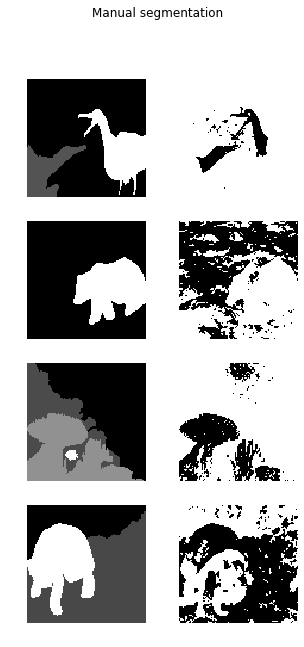

In [0]:
segmented_img = (X_segmented*255).astype(np.uint8)
fig, ax = plt.subplots(4, 2, figsize=(5,10))
fig.suptitle("Manual segmentation")
ind = 0
for i in ax:
    i[0].imshow(Image.fromarray(origy[ind]), cmap='gray', vmin=0, vmax=255)
    i[1].imshow(Image.fromarray(segmented_img[ind]), cmap='gray', vmin=0, vmax=255)
    i[0].set_axis_off()
    i[1].set_axis_off()
    ind += 1

Se ve que los resultados de esta tecnica son bastante similares a la anterior.

In [0]:
Y_label = Y_image.flatten() > 0.5
Y_hat_label = X_segmented.flatten() > 0.5
print(precision_score(Y_label, Y_hat_label, average=None, labels=[0,1] ))
print(recall_score(Y_label, Y_hat_label, average=None , labels=[0,1]))

[0.71230929 0.34408378]
[0.41657354 0.645275  ]


Y los valores de precision y recall también son muy cercanos a la tecnica usada anteriormente.


**f) Experimente con realizar data augmentation sobre el problema. Debido a que las operaciones clásicas de augmentation como rotar, invertir, girar, cambiarian la etiqueta de segmentación, genere una estrategia que mantenga la etiqueta/salida 𝑌. Se presenta un código de ejemplo, Denoising, de aplicar una máscara binaria aleatoria sobre la imagen de entrada 𝑋, de todas formas se espera que proponga alguna distinta. Compare el desempeño alcanzado con la nueva red con la forma de evaluar definida en (d).**

Primero se experimenta aumentado los datos agregandoles ruido. 

In [0]:
T = 100
for _ in range(T):
    noise_level = np.random.randint(4,10)/10.
    noise_mask = binomial(n=1,p=noise_level,size=X_image.shape)
    X_augmented = X_image*noise_mask
    model.fit(X_augmented, Y_image, epochs=10, batch_size=16, validation_data=(X_image, Y_image))

Train on 100 samples, validate on 100 samples
Epoch 1/10
100/100 [==============================] - 0s 5ms/sample - loss: 0.7573 - acc: 0.5325 - val_loss: 0.4905 - val_acc: 0.6118
Epoch 2/10
100/100 [==============================] - 0s 2ms/sample - loss: 0.5643 - acc: 0.5742 - val_loss: 0.5036 - val_acc: 0.6306
Epoch 3/10
100/100 [==============================] - 0s 2ms/sample - loss: 0.5402 - acc: 0.5915 - val_loss: 0.5766 - val_acc: 0.6021
Epoch 4/10
100/100 [==============================] - 0s 2ms/sample - loss: 0.5205 - acc: 0.6006 - val_loss: 0.5815 - val_acc: 0.6158
Epoch 5/10
100/100 [==============================] - 0s 2ms/sample - loss: 0.5186 - acc: 0.6005 - val_loss: 0.8776 - val_acc: 0.5936
Epoch 6/10
100/100 [==============================] - 0s 2ms/sample - loss: 0.5206 - acc: 0.6005 - val_loss: 0.6991 - val_acc: 0.6027
Epoch 7/10
100/100 [==============================] - 0s 2ms/sample - loss: 0.5451 - acc: 0.5900 - val_loss: 0.6033 - val_acc: 0.6064
Epoch 8/10
100/1

In [0]:
X_augmented.shape

(100, 100, 100, 3)

Precision: [0.94042131 0.95768672]
Recall: [0.98055906 0.87628468]


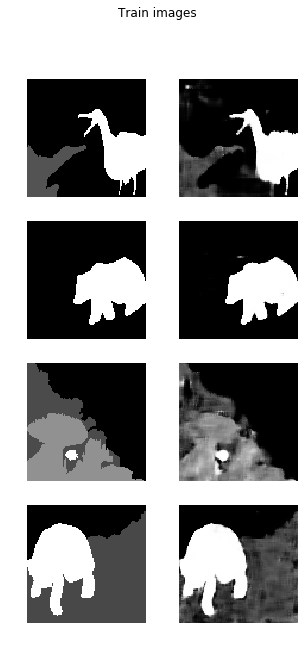

In [0]:
Y_hat_train = np.squeeze(model.predict(x_train))
Y_hat_test = np.squeeze(model.predict(x_test))
y_hat_img = (Y_hat_train*255).astype(np.uint8)
y_hat_test_img = (Y_hat_test*255).astype(np.uint8)

fig, ax = plt.subplots(4,2, figsize=(5,10))
fig.suptitle("Train images")
ind = 0
for i in ax:
    i[0].imshow(Image.fromarray(origy[ind]), cmap='gray', vmin=0, vmax=255)
    i[1].imshow(Image.fromarray(y_hat_img[ind]), cmap='gray', vmin=0, vmax=255)
    i[0].set_axis_off()
    i[1].set_axis_off()
    ind += 1
    
Y_label = y_train.flatten() > 0.5
Y_hat_label = Y_hat_train.flatten() > 0.5
print("Precision:", precision_score(Y_label, Y_hat_label, average=None, labels=[0,1] ))
print("Recall:", recall_score(Y_label, Y_hat_label, average=None , labels=[0,1]))

Se puede ver que aumentar los datos con nuevas imagenes ayudo mucho al desempeño del modelo. logrando precision y recall muy cercanos a 1.

Luego, se experimenta con otra forma de aumentar los datos, que consiste en variar levemente el brillo y saturacion de las imagenes:

In [0]:
model = newModel()
h = trainModel(x_train, y_train, x_test, y_test, model, 16)

imgsx = []
for i in origx:
    imgsx.append(Image.fromarray(i))

bright = []
dark = []
mcolor = []
lcolor = []
for i in imgsx: 
    b = ImageEnhance.Brightness(i)
    c = ImageEnhance.Color(i)
    bright.append(b.enhance(2))
    dark.append(b.enhance(0.5))
    mcolor.append(c.enhance(2))
    lcolor.append(c.enhance(0.5))

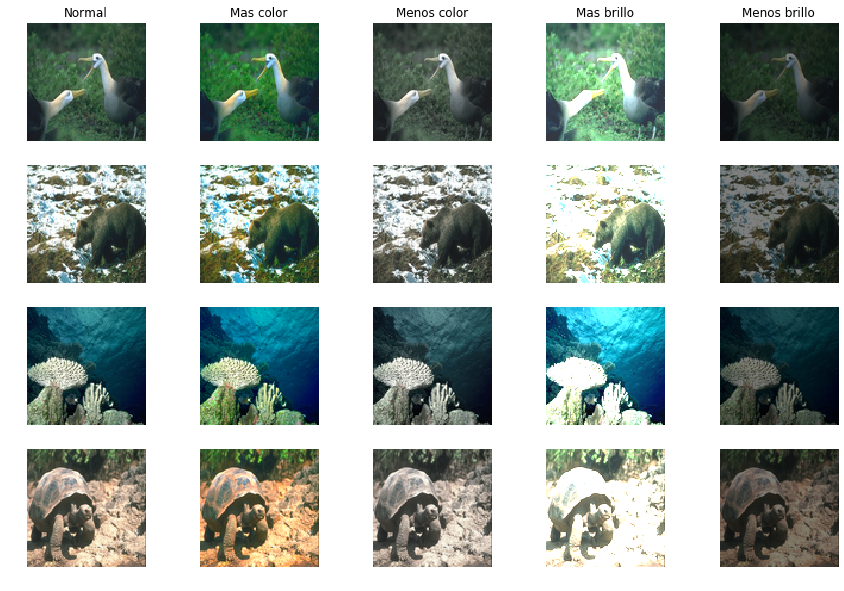

In [0]:
fig, ax = plt.subplots(4, 5, figsize=(15,10))
titles = ["Normal", "Mas color", "Menos color", "Mas brillo", "Menos brillo"]
ind = 0

for a, col in zip(ax[0], titles):
    a.set_title(col)
    
for i in ax: 
    i[0].imshow(imgsx[ind])
    i[1].imshow(mcolor[ind])
    i[2].imshow(lcolor[ind])
    i[3].imshow(bright[ind])
    i[4].imshow(dark[ind])
    i[0].set_axis_off()
    i[1].set_axis_off()
    i[2].set_axis_off()
    i[3].set_axis_off()
    i[4].set_axis_off()
    ind += 1

Ordenar para no tener que pasar de array a img y viceversa un millon de veces y media :)

In [0]:
X_augmented = lcolor + mcolor + bright + dark
X_augmented = np.array([np.asarray(i) for i in X_augmented])
X_augmented = X_augmented/255.
Y_augmented = np.concatenate((Y_image, Y_image, Y_image, Y_image))

In [0]:
history = model.fit(X_augmented, Y_augmented, epochs=300, batch_size=32, validation_data=(X_image, Y_image))

Train on 400 samples, validate on 100 samples
Epoch 1/300
400/400 [==============================] - 1s 2ms/sample - loss: 0.4523 - acc: 0.6430 - val_loss: 0.3515 - val_acc: 0.6778
Epoch 2/300
400/400 [==============================] - 1s 1ms/sample - loss: 0.4294 - acc: 0.6493 - val_loss: 0.3795 - val_acc: 0.6721
Epoch 3/300
400/400 [==============================] - 1s 1ms/sample - loss: 0.4197 - acc: 0.6550 - val_loss: 0.3726 - val_acc: 0.6693
Epoch 4/300
400/400 [==============================] - 1s 1ms/sample - loss: 0.4087 - acc: 0.6599 - val_loss: 0.3905 - val_acc: 0.6562
Epoch 5/300
400/400 [==============================] - 1s 1ms/sample - loss: 0.4073 - acc: 0.6572 - val_loss: 0.3500 - val_acc: 0.6775
Epoch 6/300
400/400 [==============================] - 1s 1ms/sample - loss: 0.4008 - acc: 0.6617 - val_loss: 0.3695 - val_acc: 0.6747
Epoch 7/300
400/400 [==============================] - 1s 1ms/sample - loss: 0.4009 - acc: 0.6599 - val_loss: 0.3790 - val_acc: 0.6684
Epoch 8/3

Precision: [0.96410778 0.97479923]
Recall: [0.98796958 0.92675136]


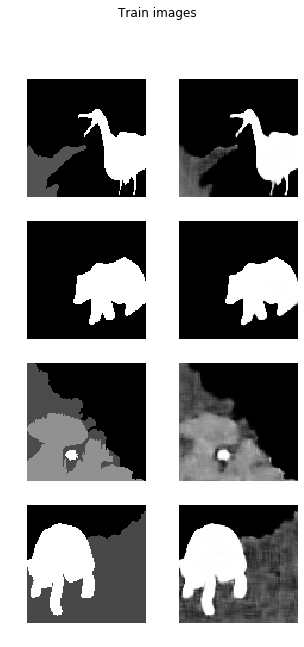

In [0]:
Y_hat_train = np.squeeze(model.predict(x_train))
Y_hat_test = np.squeeze(model.predict(x_test))
y_hat_img = (Y_hat_train*255).astype(np.uint8)
y_hat_test_img = (Y_hat_test*255).astype(np.uint8)

fig, ax = plt.subplots(4,2, figsize=(5,10))
fig.suptitle("Train images")
ind = 0
for i in ax:
    i[0].imshow(Image.fromarray(origy[ind]), cmap='gray', vmin=0, vmax=255)
    i[1].imshow(Image.fromarray(y_hat_img[ind]), cmap='gray', vmin=0, vmax=255)
    i[0].set_axis_off()
    i[1].set_axis_off()
    ind += 1
    
Y_label = y_train.flatten() > 0.5
Y_hat_label = Y_hat_train.flatten() > 0.5
print("Precision:", precision_score(Y_label, Y_hat_label, average=None, labels=[0,1] ))
print("Recall:", recall_score(Y_label, Y_hat_label, average=None , labels=[0,1]))

Este metodo de aumentar los datos tambien dio resultados bastante buenos, dejando precisio y recall por sobre 0.9.

**g) Intente variar la arquitectura presentada en pos de obtener un mejor modelo, basado en la evaluación realizada en (d). Recuerde tomar en cuenta la poca cantidad de datos que se tiene**

Se agrega batchnormalization a la red con el objetivo de disminuir el overfitting.

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 100, 100, 32)      896       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 50, 50, 32)        128       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 50, 50, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 25, 25, 64)       

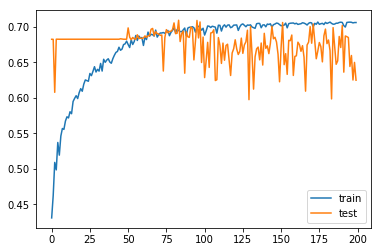

In [0]:
def newModel():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=X_image.shape[1:]))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPool2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPool2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))

    model.add(UpSampling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(32, (3, 3), activation='relu', padding='same'))
    model.add(Conv2DTranspose(32, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2DTranspose(1, (3, 3), strides=(2,2), activation='sigmoid', padding='same'))
    
    return model

newModel().summary()

def trainModel(x, y, xt, yt, model, bs):
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=["accuracy"])
    history = model.fit(x, y, epochs=200, batch_size=bs, validation_data=(xt, yt), verbose=0)
    return history


model = newModel()
h = trainModel(x_train, y_train, x_test, y_test, model, 16)
plt.figure()
plt.plot(h.history['acc'], label='train')
plt.plot(h.history['val_acc'], label='test')
plt.legend()

Precision: [0.9577538  0.89738251]
Recall: [0.94735858 0.91677968]

Test Precision: [0.89421631 0.42560801]
Test Recall: [0.76662286 0.65597738]


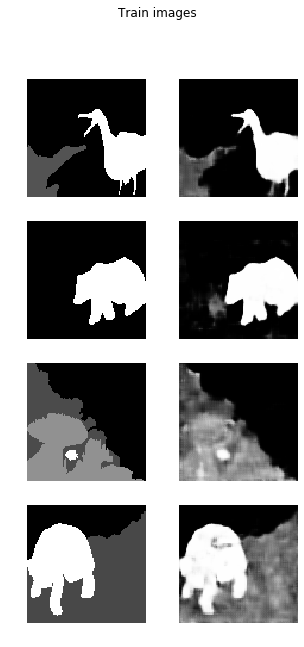

In [0]:
Y_hat_train = np.squeeze(model.predict(x_train))
Y_hat_test = np.squeeze(model.predict(x_test))
y_hat_img = (Y_hat_train*255).astype(np.uint8)
y_hat_test_img = (Y_hat_test*255).astype(np.uint8)
fig, ax = plt.subplots(4,2, figsize=(5,10))
fig.suptitle("Train images")

ind = 0
for i in ax:
    i[0].imshow(Image.fromarray(origy[ind]), cmap='gray', vmin=0, vmax=255)
    i[1].imshow(Image.fromarray(y_hat_img[ind]), cmap='gray', vmin=0, vmax=255)
    i[0].set_axis_off()
    i[1].set_axis_off()
    ind += 1
    
Y_label = y_train.flatten() > 0.5
Y_hat_label = Y_hat_train.flatten() > 0.5
print("Precision:", precision_score(Y_label, Y_hat_label, average=None, labels=[0,1] ))
print("Recall:", recall_score(Y_label, Y_hat_label, average=None , labels=[0,1]))

Y_label = y_test.flatten() > 0.5
Y_hat_label = Y_hat_test.flatten() > 0.5
print("\nTest Precision:", precision_score(Y_label, Y_hat_label, average=None, labels=[0,1] ))
print("Test Recall:", recall_score(Y_label, Y_hat_label, average=None , labels=[0,1]))

Cuantitativamente, los resultados son muy similares a los obtenidos con la otra red. Cualitativamente, se ve que las imagenes tienen bordes mucho más definidos, al meno en el caso del conjunto de entrenamiento.

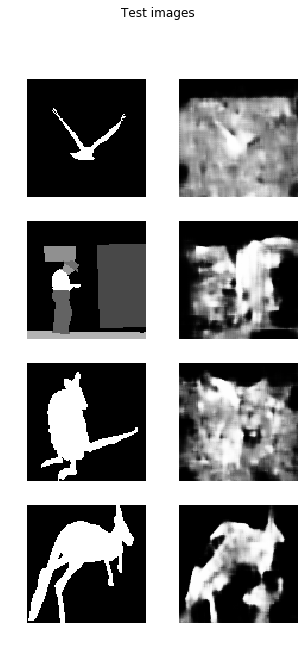

In [0]:
fig, ax = plt.subplots(4,2, figsize=(5,10))
fig.suptitle("Test images")
ind = 0
for i in ax:
    i[0].imshow(Image.fromarray(origy[90+ind]), cmap='gray', vmin=0, vmax=255)
    i[1].imshow(Image.fromarray(y_hat_test_img[ind]), cmap='gray', vmin=0, vmax=255)
    i[0].set_axis_off()
    i[1].set_axis_off()
    ind += 1

En el caso del conjunto de prueba, los resultados aun no son muy buenos, pero parecen ser mejores que con la red probada al comienzo.